# Challenge: Factors that affect life expectancy

Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who/home) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which 
factors decrease it.

In [135]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

In [2]:
# read in us education data 

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_exp = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [14]:
# clean column labels

find_rep = {' ': '_',
            '/': '_'}

for item in find_rep:
    life_exp.columns = life_exp.columns.str.replace(item, find_rep[item])

life_exp.columns = map(str.lower, life_exp.columns)

In [15]:
life_exp.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
life_exp.shape

(2938, 22)

In [23]:
life_exp.dtypes

country                             object
year                                 int64
status                              object
life_expectancy_                   float64
adult_mortality                    float64
infant_deaths                        int64
alcohol                            float64
percentage_expenditure             float64
hepatitis_b                        float64
measles_                             int64
_bmi_                              float64
under-five_deaths_                   int64
polio                              float64
total_expenditure                  float64
diphtheria_                        float64
_hiv_aids                          float64
gdp                                float64
population                         float64
_thinness__1-19_years              float64
_thinness_5-9_years                float64
income_composition_of_resources    float64
schooling                          float64
dtype: object

### 1. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [81]:
len(life_exp.iloc[0,0])

11

In [59]:
life_exp.status.value_counts()

Developing    2426
Developed      512
Name: status, dtype: int64

In [93]:
# how many nan values are there for each column?
life_exp.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy_                    10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles_                             0
_bmi_                               34
under-five_deaths_                   0
polio                               19
total_expenditure                  226
diphtheria_                         19
_hiv_aids                            0
gdp                                448
population                         652
_thinness__1-19_years               34
_thinness_5-9_years                 34
income_composition_of_resources    167
schooling                          163
dtype: int64

In [94]:
# for each country, interpolate to fill na values
# since this is time series data 
# my guess is that most trends will change 
# in the same direction for all countries.

for col in life_exp.columns[3:]:
    for country in life_exp.country.unique():
        life_exp.loc[life_exp['country'] == country, col] = \
        life_exp.loc[life_exp['country'] == country, col].fillna(
        life_exp.loc[life_exp['country'] == country, col].interpolate())

In [103]:
# verify nan values are filled
# I'm still left with a large number of nan values
# should I just drop these?
life_exp.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy_                    10
adult_mortality                     10
infant_deaths                        0
alcohol                            192
percentage_expenditure               0
hepatitis_b                        144
measles_                             0
_bmi_                               34
under-five_deaths_                   0
polio                                0
total_expenditure                  210
diphtheria_                          0
_hiv_aids                            0
gdp                                422
population                         652
_thinness__1-19_years               34
_thinness_5-9_years                 34
income_composition_of_resources    167
schooling                          163
dtype: int64

In [101]:
life_exp[life_exp.life_expectancy_.isna()]

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling
624,Cook Islands,2013,Developing,NaN,NaN,0,0.01,0.000000,98.0,0,82.8,0,98.0,3.58,98.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
769,Dominica,2013,Developing,NaN,NaN,0,0.01,11.419555,96.0,0,58.4,0,96.0,5.58,96.0,0.1,722.756650,NaN,2.7,2.6,0.721,12.7
1651,Marshall Islands,2013,Developing,NaN,NaN,0,0.01,871.878317,8.0,0,81.6,0,79.0,17.24,79.0,0.1,3617.752354,NaN,0.1,0.1,NaN,0.0
1716,Monaco,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,NaN,0,99.0,4.30,99.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1813,Nauru,2013,Developing,NaN,NaN,0,0.01,15.606596,87.0,0,87.3,0,87.0,4.65,87.0,0.1,136.183210,NaN,0.1,0.1,NaN,9.6
1910,Niue,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,77.3,0,99.0,7.20,99.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
1959,Palau,2013,Developing,NaN,NaN,0,NaN,344.690631,99.0,0,83.3,0,99.0,9.27,99.0,0.1,1932.122370,292.0,0.1,0.1,0.779,14.2
2168,Saint Kitts and Nevis,2013,Developing,NaN,NaN,0,8.54,0.000000,97.0,0,5.2,0,96.0,6.14,96.0,0.1,NaN,NaN,3.7,3.6,0.749,13.4
2217,San Marino,2013,Developing,NaN,NaN,0,0.01,0.000000,69.0,0,NaN,0,69.0,6.50,69.0,0.1,NaN,NaN,NaN,NaN,NaN,15.1
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.01,78.281203,9.0,0,79.3,0,9.0,16.61,9.0,0.1,3542.135890,1819.0,0.2,0.1,NaN,0.0


In [108]:
# fill nan values for the entire column
# instead of by column and country

for col in life_exp.columns[3:]:
    life_exp.loc[:, col] = \
    life_exp.loc[:, col].fillna(
    life_exp.loc[:, col].interpolate())

In [109]:
# how many nan values are there for each column?
# this method removed all nan values
# but probably isn't as effective as the first method?
life_exp.isna().sum()

country                            0
year                               0
status                             0
life_expectancy_                   0
adult_mortality                    0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b                        0
measles_                           0
_bmi_                              0
under-five_deaths_                 0
polio                              0
total_expenditure                  0
diphtheria_                        0
_hiv_aids                          0
gdp                                0
population                         0
_thinness__1-19_years              0
_thinness_5-9_years                0
income_composition_of_resources    0
schooling                          0
dtype: int64

In [114]:
# identify columns that have at least one
# data point that lies outside the 99th percentile
# for that column
for column in life_exp.columns[3:]:
    if len(np.where(zscore(life_exp[column]) > 3)[0]) > 1:
        print(column)
        print(len(np.where(zscore(life_exp[column]) > 3)[0]))

adult_mortality
40
infant_deaths
37
alcohol
4
percentage_expenditure
84
measles_
48
under-five_deaths_
34
total_expenditure
26
_hiv_aids
69
gdp
87
population
22
_thinness__1-19_years
53
_thinness_5-9_years
55


There are a lot of outliers beyond 3 standard deviations.

### 2. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.


#### Univariate analysis

In [115]:
# descriptive staticts
life_exp.describe()

,year,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,30.303948,4.548330,738.251295,76.029272,2419.592240,38.29869,42.035739,82.307692,5.925851,82.075221,1.742103,7382.640400,1.229209e+07,4.882301,4.920439,0.634458,12.076804
std,4.613841,9.510819,124.226596,117.926501,3.995164,1987.914858,28.359428,11467.272489,19.99140,160.445548,23.636677,2.451693,23.917022,5.077785,13412.320229,5.471908e+07,4.433359,4.532488,0.209574,3.342316
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,66.000000,0.000000,19.32500,0.000000,77.000000,4.300000,78.000000,0.100000,542.227967,2.536025e+05,1.600000,1.600000,0.500000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,93.000000,5.730000,93.000000,0.100000,2124.768139,1.576319e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,97.000000,7.437500,97.000000,0.800000,7077.188915,8.215738e+06,7.200000,7.300000,0.791107,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.30000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


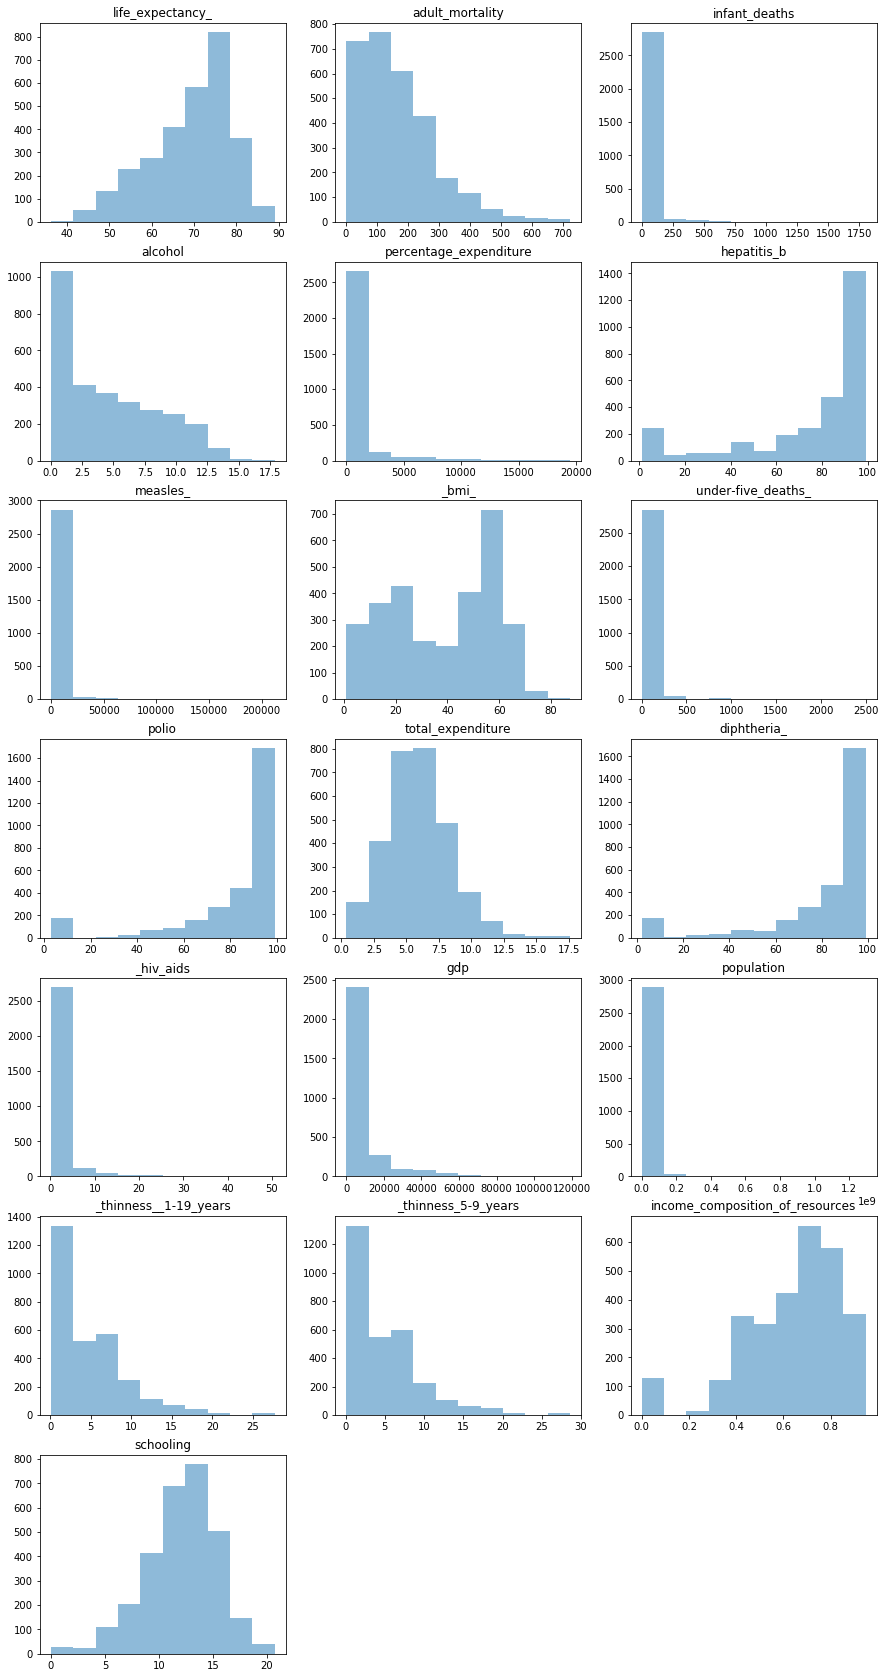

In [137]:
# show histogram for each column
# to show the distribution of the data

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp.columns[3:]):

    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

In [138]:
life_exp.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


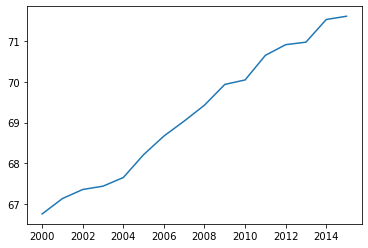

In [146]:
# plot life expectancy across time
# aggregated for all countries

x = life_exp[['year', 'life_expectancy_']].groupby('year').mean().index
y = life_exp[['year', 'life_expectancy_']].groupby('year').mean().iloc[:,0]

plt.plot(x, y);

Clearly, life expectancy has been going up over time.

#### Multivariate Analysis

In [155]:
# which of the attributes correlates most strongly with life_expectancy?
life_exp.corr().iloc[:,1].sort_values(ascending=False)

life_expectancy_                   1.000000
schooling                          0.703409
income_composition_of_resources    0.690071
_bmi_                              0.556433
diphtheria_                        0.473851
polio                              0.459201
gdp                                0.441807
alcohol                            0.400284
percentage_expenditure             0.382069
hepatitis_b                        0.304380
total_expenditure                  0.218518
year                               0.168309
population                        -0.007126
measles_                          -0.157298
infant_deaths                     -0.196197
under-five_deaths_                -0.222151
_thinness_5-9_years               -0.472485
_thinness__1-19_years             -0.476809
_hiv_aids                         -0.555929
adult_mortality                   -0.695730
Name: life_expectancy_, dtype: float64

Schooling appears to be the most highly correlated with life expectancy.

In [156]:
# which of the attributes correlates most negatively with life_expectancy?
life_exp.corr().iloc[:,1].sort_values()

adult_mortality                   -0.695730
_hiv_aids                         -0.555929
_thinness__1-19_years             -0.476809
_thinness_5-9_years               -0.472485
under-five_deaths_                -0.222151
infant_deaths                     -0.196197
measles_                          -0.157298
population                        -0.007126
year                               0.168309
total_expenditure                  0.218518
hepatitis_b                        0.304380
percentage_expenditure             0.382069
alcohol                            0.400284
gdp                                0.441807
polio                              0.459201
diphtheria_                        0.473851
_bmi_                              0.556433
income_composition_of_resources    0.690071
schooling                          0.703409
life_expectancy_                   1.000000
Name: life_expectancy_, dtype: float64

HIV Aids appears to be most highly negatively correlated with life expectancy.

### 3.  In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.


### 4. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.
